In [24]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine,reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

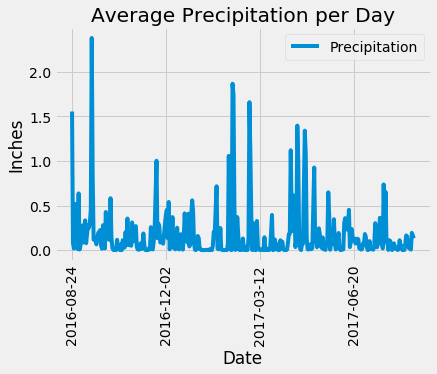

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
year_ago = dt.datetime.strptime(last_date[0],"%Y-%m-%d") - dt.timedelta(days=365)
# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date,func.avg(Measurement.prcp)).\
    group_by(Measurement.date).\
    filter(Measurement.date > year_ago).\
    order_by(Measurement.date).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(results,columns=["Date","Precipitation"])
prcp_df = prcp_df.set_index("Date")
# # Sort the dataframe by date
prcp_df_sorted = prcp_df.sort_index()
# Use Pandas Plotting with Matplotlib to plot the data
prcp_df_sorted.plot()
plt.xticks(rotation=90)
plt.ylabel("Inches")
plt.title("Average Precipitation per Day")
plt.show()


In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
summary = pd.DataFrame({
    "Average":[prcp_df_sorted['Precipitation'].mean()],
    "Sum":[prcp_df_sorted['Precipitation'].sum()],
    "Min":[prcp_df_sorted['Precipitation'].min()],
    "Max":[prcp_df_sorted['Precipitation'].max()],
    "Count":[prcp_df_sorted['Precipitation'].count()]
})
summary

,Average,Sum,Min,Max,Count
0,0.169987,62.045357,0.0,2.38,365


In [12]:
# Design a query to show how many stations are available in this dataset?
station_results = session.query(Measurement.date,Measurement.station,Measurement.prcp,Measurement.tobs).\
    order_by(Measurement.date).all()
station_df = pd.DataFrame(station_results,columns=["Date","Station","Precipitation","Temperature"])
print(f"There are {len(station_df['Station'].unique())} stations in this dataset.")


There are 9 stations in this dataset.


In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_count = station_df.groupby('Station').count().sort_values(by="Date",ascending=False)
station_count

,Date,Precipitation,Temperature
Station,,,
USC00519281,2772,2772,2772
USC00519397,2724,2685,2724
USC00513117,2709,2696,2709
USC00519523,2669,2572,2669
USC00516128,2612,2484,2612
USC00514830,2202,1937,2202
USC00511918,1979,1932,1979
USC00517948,1372,683,1372
USC00518838,511,342,511


In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
station_recs = pd.DataFrame({
    "Average":[station_df.loc[station_df['Station']=="USC00519281"]['Temperature'].mean()],
    "Min":[station_df.loc[station_df['Station']=="USC00519281"]['Temperature'].min()],
    "Max":[station_df.loc[station_df['Station']=="USC00519281"]['Temperature'].max()]
})
station_recs

,Average,Min,Max
0,71.663781,54.0,85.0


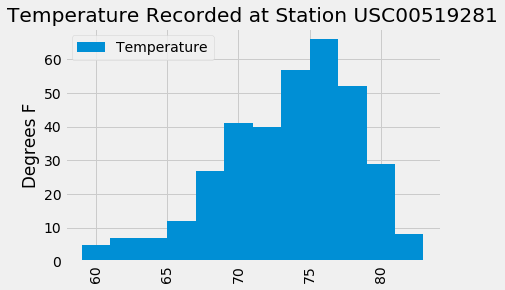

In [15]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
one_station_results = session.query(Measurement.date,Measurement.station,Measurement.tobs).\
    group_by(Measurement.date).\
    filter(Measurement.date > year_ago).\
    filter_by(station = 'USC00519281').\
    order_by(Measurement.date).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
one_station_df = pd.DataFrame(one_station_results,columns=["Date","Station","Temperature"])
one_station_df = one_station_df.set_index("Date")
one_station_df = one_station_df .drop(columns=['Station'])
one_station_df 
# Use Pandas Plotting with Matplotlib to plot the data
one_station_df.plot(kind="hist",bins=12)
plt.xticks(rotation=90)
plt.ylabel("Degrees F")
plt.title("Temperature Recorded at Station USC00519281")
plt.show()


## Bonus Challenge Assignment

In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [31]:
# Comparison of temperatures in June and December
# selection of all precipitations per month
station_df['Month'] = pd.DatetimeIndex(station_df['Date']).month
june = pd.DataFrame(station_df.loc[station_df['Month']==6]['Precipitation']).dropna(how='any')
dec = pd.DataFrame(station_df.loc[station_df['Month']==12]['Precipitation']).dropna(how='any')
stats.ttest_ind(june['Precipitation'], dec['Precipitation'], equal_var=False)

Ttest_indResult(statistic=-4.806345313914344, pvalue=1.6366855096194443e-06)

In [55]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start_date = '2016-10-19'
end_date = '2016-10-30'
vacay_check = calc_temps(start_date,end_date)
vacay_check

[[68.0, 81.0]]

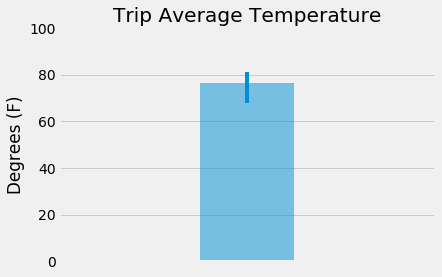

In [88]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
lower = vacay_check[0][1]-vacay_check[0][0]
upper = vacay_check[0][2]-vacay_check[0][1]
y = vacay_check[0][1]
asym_error = [lower,upper]
plt.bar(1,y,width=0.1,align='center',alpha=.5)
plt.errorbar(1,y,np.array([asym_error]).T)
plt.xticks([])
plt.title("Trip Average Temperature")
plt.ylabel("Degrees (F)")
plt.ylim(0,100)
plt.xlim(.8,1.2)
plt.show()

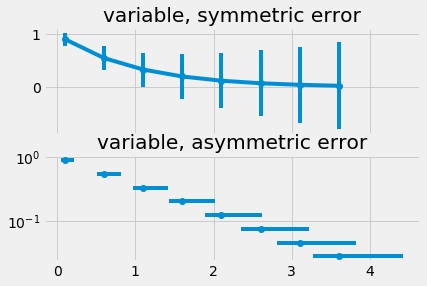

In [71]:
import numpy as np
import matplotlib.pyplot as plt

# example data
x = np.arange(0.1, 4, 0.5)
y = np.exp(-x)

# example error bar values that vary with x-position
error = 0.1 + 0.2 * x

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True)
ax0.errorbar(x, y, yerr=error, fmt='-o')
ax0.set_title('variable, symmetric error')

# error bar values w/ different -/+ errors that
# also vary with the x-position
lower_error = 0.4 * error
upper_error = error
asymmetric_error = [lower_error, upper_error]

ax1.errorbar(x, y, xerr=asymmetric_error, fmt='o')
ax1.set_title('variable, asymmetric error')
ax1.set_yscale('log')
plt.show()

In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
